In [1]:
! pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 22 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=723a5b2efd1d75da7b5c9c3f691c016b3dd4dc4332322a24e1b7cbc6fc069393
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [15]:
from google.colab import drive # Импортим видосы с гугл драйва
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### В качестве модели была использована MesoNet, конкретно Meso4

In [3]:
# Основы проектной деятельности
# Алгоритм обнаружения DeepFake с использованием модели MesoNet
# Цветков Тимофей, Заболотный Артём, Морозов Максим, Фурсов Никита, Соколова Александра
#
# В работе использовалась БД видео с сайта kaggle.com
# Данные о работе MesoNet брались с репозитория: https://github.com/DariusAf/MesoNet
# Все данные брались из открытых источников
# 2022 год
from keras.models import Model as KerasModel
from keras.layers import Input, Dense,Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

import os    #
import glob  # Вспомогательные элементы
import torch # для корректной работы классификатора
import cv2   #
from PIL import Image
import numpy as np # Для массивов в конце 
import pandas as pd
from matplotlib import pyplot as plt
IMGWIDTH = 256 # Всмомогательная шняга для 
import face_recognition # Либа для детекта лиц на видосах


In [4]:

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

# Простейший классификатор для модели Meso4
class Meso4(Classifier):
    def __init__(self, learning_rate=0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=['accuracy'])
    
    def init_model(self):
        x = Input(shape=(IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3,3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2,2), padding='same')(x1)
        
        x2 = Conv2D(8,(5,5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2,2), padding='same')(x2)
        
        x3 = Conv2D(16, (5,5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2,2), padding='same')(x3)
        
        x4 = Conv2D(16,(5,5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4,4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)
        
        return KerasModel(x, y)

### Скачивание весов тренированной модели

In [5]:
!wget https://github.com/PacktPublishing/Machine-Learning-for-Cybersecurity-Cookbook/raw/master/Chapter04/Deepfake%20Recognition/mesonet_weights/Meso4_DF

--2022-05-25 08:19:09--  https://github.com/PacktPublishing/Machine-Learning-for-Cybersecurity-Cookbook/raw/master/Chapter04/Deepfake%20Recognition/mesonet_weights/Meso4_DF
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Cybersecurity-Cookbook/master/Chapter04/Deepfake%20Recognition/mesonet_weights/Meso4_DF [following]
--2022-05-25 08:19:09--  https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Cybersecurity-Cookbook/master/Chapter04/Deepfake%20Recognition/mesonet_weights/Meso4_DF
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156128 (152K

In [6]:

from keras.preprocessing.image import ImageDataGenerator

MesoNet_classifier = Meso4()
MesoNet_classifier.load("/content/Meso4_DF")
#MesoNet_classifier.load("Meso4_DF") #/content/Meso4_DF

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Попытка оптимизировать код с помощью GPU не зашёл, коллаб что-то не смог
#
#from facenet_pytorch import MTCNN, InceptionResnetV1

#device = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
#print(f'Running on device: {device}')
#torch.cuda.get_device_name(0)

###Получение видео и работа  с ними


In [22]:
# Подгружаем все тестовые видео
# filenames = glob.glob(f'/content/drive/MyDrive/Colab Notebooks/test_videos/*.mp4')
filenames = glob.glob(f'/content/drive/MyDrive/didk/*.mp4')
# Их общее количество:
print("Filecount: {}".format(len(filenames)))
# Количество кадров для выборки из каждого видео, то есть буквально разбивка видео
n_frames = 100
is_face = 0
with torch.no_grad():
    face_list_whole_data=[]
    # Здесь можно задать количество просматриваемых видео, стоит :5, таким образом анализируем лишь 5 видосов
    for i, filename in enumerate(filenames[:5]):
        is_face = 0 
        print(f'Processing {i+1:5n} of {len(filenames):5n} videos\r')   
        try:
            # Считываем видео и находим длину, используя cv2
            v_cap = cv2.VideoCapture(filename)
            v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
            # Выбор n_framce равномерно расположенных кадров для выборки
            sample = np.linspace(0, v_len - 1, n_frames).round().astype(int)
            face_list_1video = []
            for j in range(v_len):
                if j in sample:
                    success, vframe = v_cap.read()                           # 
                    vframe = cv2.cvtColor(vframe, cv2.COLOR_BGR2RGB)         # Здесь мы находим лица на видео
                    face_locations = face_recognition.face_locations(vframe) #
                    face_list_1frame=[]
                    for face_location in face_locations:
                        is_face = 1
                    # Тут можно отследить лица на видео, фактически для дебага
                        top, right, bottom, left = face_location
                        print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
                    # Тут же мы просматриваем сам лицо 
                        face_image = vframe[top:bottom, left:right]
                        res = cv2.resize(face_image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
                        face_list_1frame.append(res/255)
                    face_list_1video.append(face_list_1frame)
            if(is_face == 0):
              print("Face not detected")
            is_face = 0
            face_list_whole_data.append(face_list_1video)
        except KeyboardInterrupt:
            raise Exception("Stopped.") # Можем стопнуть с помощью клавы

Filecount: 2
Processing     1 of     2 videos
A face is located at pixel location Top: 0, Left: 134, Bottom: 277, Right: 455
A face is located at pixel location Top: 0, Left: 134, Bottom: 313, Right: 455
A face is located at pixel location Top: 0, Left: 134, Bottom: 313, Right: 455
A face is located at pixel location Top: 27, Left: 170, Bottom: 348, Right: 491
A face is located at pixel location Top: 27, Left: 170, Bottom: 348, Right: 491
A face is located at pixel location Top: 63, Left: 170, Bottom: 384, Right: 491
A face is located at pixel location Top: 63, Left: 170, Bottom: 384, Right: 491
A face is located at pixel location Top: 99, Left: 170, Bottom: 420, Right: 491
A face is located at pixel location Top: 134, Left: 205, Bottom: 455, Right: 526
A face is located at pixel location Top: 134, Left: 205, Bottom: 455, Right: 526
A face is located at pixel location Top: 170, Left: 205, Bottom: 491, Right: 526
A face is located at pixel location Top: 206, Left: 205, Bottom: 527, Righ

### Можем посмотреть на какое-то найденное лицо на видео

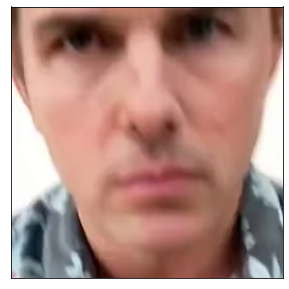

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
plt.grid(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.imshow(face_list_whole_data[0][1][0])
#print(face_list_whole_data)

In [24]:
all_prob_list=[0]*len(face_list_whole_data)

#face_list_whole_data[0].pop(0)
#face_list_whole_data[0].pop(0)
#face_list_whole_data[0].pop(0)
#face_list_whole_data[0].pop(0)
#face_list_whole_data[0].pop(0)
#face_list_whole_data[0].pop(0)
#face_list_whole_data = [x for x in face_list_whole_data if x]

#print(face_list_whole_data)
no_face = []
for i, video in enumerate(face_list_whole_data):
  #print(video)
  prob_list=[]
  for j, frame in enumerate(video):
      if(len(frame) == 0):
        no_face.append(frame)
        continue
      img_array=np.array(frame)
      probabilistic_predictions = MesoNet_classifier.predict(img_array)
      prob_list.append(probabilistic_predictions)
  all_prob_list[i]=prob_list
      #predictions = [num_to_label[round(x[0])] for x in probabilistic_predictions]
      #print(predictions)

In [25]:
all_prob_list

[[array([[0.20312694]], dtype=float32),
  array([[0.39251855]], dtype=float32),
  array([[0.67498404]], dtype=float32),
  array([[0.51631296]], dtype=float32),
  array([[0.692769]], dtype=float32),
  array([[0.7078378]], dtype=float32),
  array([[0.69396204]], dtype=float32),
  array([[0.76163054]], dtype=float32),
  array([[0.66727275]], dtype=float32),
  array([[0.38470536]], dtype=float32),
  array([[0.6445327]], dtype=float32),
  array([[0.58356774]], dtype=float32),
  array([[0.6859262]], dtype=float32),
  array([[0.732599]], dtype=float32),
  array([[0.64935285]], dtype=float32),
  array([[0.71167517]], dtype=float32),
  array([[0.7479373]], dtype=float32),
  array([[0.7336215]], dtype=float32),
  array([[0.8915313]], dtype=float32),
  array([[0.71697474]], dtype=float32),
  array([[0.9395414]], dtype=float32),
  array([[0.9838514]], dtype=float32),
  array([[0.98189294]], dtype=float32),
  array([[0.90665054]], dtype=float32),
  array([[0.96370006]], dtype=float32),
  array([[0.

In [26]:

submission = []
#subm_prob=[]
for filename, prob in zip(filenames, all_prob_list):
    indiv_prob=[]  
    if prob is not None: #and len(prob) >= n_frames: 
        #print("zxc")  
        for i in prob:
            indiv_prob.append(i)
    #subm_prob.append(indiv_prob)
    #else: prob = 0.5
    if(len(indiv_prob) != 0):
      submission.append([os.path.basename(filename), sum(indiv_prob)/len(indiv_prob)])
        

In [27]:
submission

[['1614345013263016596_576x1024.mp4', array([[0.9099672 ],
         [0.88899755]], dtype=float32)],
 ['1614345634296841861_576x1024.mp4', array([[0.73629516],
         [0.72162735]], dtype=float32)]]

In [ ]:
num_to_label = {1:"real", 0:"fake"}

pred_value = []
for i in range(0, 4):
  pred_value.append(submission[i][1][0][0])
  if(pred_value[i] < 0.5):
    pred_value[i] = '0'
  else:
    pred_value[i] = '1'
print(pred_value)
actual_value = ['1', '1', '0', '1']
print(metrics.accuracy_score(actual_value, pred_value))
print(metrics.classification_report(actual_value, pred_value, labels=[1, 0]))
#y_pred = ["a", "b", "c", "a", "b"]
# Actual values
#y_act = ["a", "b", "c", "c", "a"]
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
#print(metrics.confusion_matrix(y_act, y_pred, labels=["a", "b", "c"]))
# Printing the precision and recall, among other metrics
#print(metrics.classification_report(y_act, y_pred, labels=["a", "b","c"]))


['1', '0', '1', '1']
0.5
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           0       0.00      0.00      0.00         1

   micro avg       0.50      0.50      0.50         4
   macro avg       0.33      0.33      0.33         4
weighted avg       0.50      0.50      0.50         4



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
